# VGG16 DL modeling on COVID-QU-Ex
In this notebook, we'll study an existing model for image recognition such as VGG16 and apply it on our dataset from Kaggle (https://www.kaggle.com/datasets/anasmohammedtahir/covidqu)

FIRST PART: Tunning
- Data will first be analyzed and prepare for modeling.
- The VGG16 model from Keras will first be tuned (using KERAS tuner) to optimize its performance.
- The optimized model (known to be the "best" VGG16 model) will then be trained of train set and validated on val set.
- The model will then be evaluated on the test set.

SECOND PART: Optimisation
- To optimize the model studied in first part, will re-train the model "un-freezing" the last convolutional layers (last 4 layers)
- The model will then be evaluated on the test set.

In this notebook, we concider the model "optimized" when the the last 4 layers of the VGG16 are un-freezed.

To conclude, we'll compare the "tuned model" and "optimized model"

In [1]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-04-27 20:34:53.053323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 20:34:53.053451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 20:34:53.154007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
# Cell to import necessary library
import numpy as np
import pandas as pd
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn import metrics

import os

## 1- Data analysis
When first running this notebook, we'll need to transfer images files to the Kaggle working directory.

In [3]:
# This cells is made to set the different directories used in this notebook
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base pat
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data'
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

In [ ]:
# Only run this cell if working files are not in kaggle working directory
import shutil

for sett in sets:
  for group in groups:
    ima_dir = os.path.join(base_path, sett, group)
    for dos in tqdm(os.listdir(ima_dir)):
        if dos=="images":
            shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

In [4]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


# 2- Data preparation

In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure image is of type uint8
    img = img.astype('uint8')
    # Equalize histogram
    img = cv2.equalizeHist(img)
    # Convert grayscale back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Preprocess for the model input
    img_preprocessed = preprocess_input(img)
    return img_preprocessed



train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)

In [6]:
# Preparation of the data set using image generator
batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           class_mode="sparse",
                                                           target_size=(224, 224),
                                                           batch_size=batch_size)

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                         class_mode="sparse",
                                                         target_size=(224, 224),
                                                         batch_size=batch_size)

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                          class_mode="sparse",
                                                          target_size=(224, 224),
                                                          batch_size=batch_size, shuffle=False)
        # shuffle=False argument is very important for model evaluation 
        #(I spend many hours trying to figure it out)

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


# 3- VGG26 Model tuning
Due to the significantly high computational duration, only 2 trial were performed to tuned only the 2 dropout rates.

In [7]:
# VGG16 model 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import VGG16
from  keras_tuner import RandomSearch
from  keras_tuner import HyperParameters
from tensorflow.keras.optimizers import Adam

# Define a function to build the model
def build_model(hp):
    # Load the pre-trained VGG16 model without the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the pre-trained layers so they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),  
        Dense(128, activation='relu'),
        Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),  
        Dense(3, activation='softmax')  # Output layer with 3 classes
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),#Will be set to 0.0001 for fine tuning
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [8]:
# Instantiate the RandomSearch tuner to search for the best hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # optimize for validation accuracy
    max_trials=2,  # try 2 different hyperparameter combinations
    executions_per_trial=1,  
    directory='/kaggle/working/COVID-EX-Qu-dataset',  # directory to save logs and checkpoints
    project_name='vgg16_tuning_3'  # name of the project
)
tuner.search_space_summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Search space summary
Default search space size: 2
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [9]:
tuner.search(train_generator,
             epochs=5,  
             validation_data=val_generator) 

Trial 2 Complete [00h 09m 30s]
val_accuracy: 0.871884822845459

Best val_accuracy So Far: 0.8744692802429199
Total elapsed time: 00h 19m 52s


In [10]:
# Retrieve and read tuned parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal dropout rate 1 is {best_hps.get('dropout_1')}.
The optimal dropout rate 2 is {best_hps.get('dropout_2')}.
""")


The optimal dropout rate 1 is 0.30000000000000004.
The optimal dropout rate 2 is 0.4.



In [11]:
# Build the model with the best hyperparameters
best_model_vgg16 = tuner.hypermodel.build(best_hps)

In [12]:
# tailes des échantillons
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples
history_vgg6_nonopt = best_model_vgg16.fit(train_generator, 
                                epochs = 10,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=test_generator,
                                validation_steps=nb_img_val//batch_size
                                )

Epoch 1/10
  1/678 ━━━━━━━━━━━━━━━━━━━━ 58:33 5s/step - accuracy: 0.3438 - loss: 6.7332

W0000 00:00:1714251357.847364     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


608/678 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.6396 - loss: 1.0991

W0000 00:00:1714251440.725943     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6481 - loss: 1.0603

W0000 00:00:1714251450.798669     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 120s 170ms/step - accuracy: 0.6482 - loss: 1.0598 - val_accuracy: 0.8238 - val_loss: 0.4398
Epoch 2/10
  1/678 ━━━━━━━━━━━━━━━━━━━━ 1:24 124ms/step - accuracy: 0.8750 - loss: 0.2804

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8750 - loss: 0.2804 - val_accuracy: 0.8899 - val_loss: 0.4380
Epoch 3/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 111s 163ms/step - accuracy: 0.7959 - loss: 0.5109 - val_accuracy: 0.8510 - val_loss: 0.3849
Epoch 4/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9062 - loss: 0.2561 - val_accuracy: 0.8457 - val_loss: 0.5057
Epoch 5/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 112s 164ms/step - accuracy: 0.8160 - loss: 0.4589 - val_accuracy: 0.8635 - val_loss: 0.3433
Epoch 6/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8438 - loss: 0.3097 - val_accuracy: 0.8841 - val_loss: 0.3358
Epoch 7/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 111s 163ms/step - accuracy: 0.8359 - loss: 0.4241 - val_accuracy: 0.8909 - val_loss: 0.3084
Epoch 8/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8125 - loss: 0.4104 - val_accuracy: 0.8312 - val_loss: 0.4937
Epoch 9/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 111s 163ms/step - accuracy: 0.8445 - loss: 0.4009 - val_accur

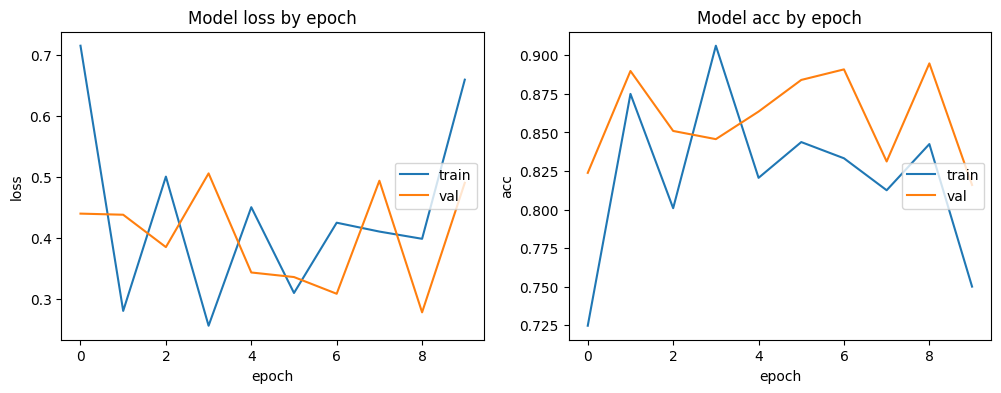

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_vgg6_nonopt.history['loss'])
plt.plot(history_vgg6_nonopt.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_vgg6_nonopt.history['accuracy'])
plt.plot(history_vgg6_nonopt.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [14]:
evaluation_nopt = best_model_vgg16.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_nopt[0])
print("Test Accuracy:", evaluation_nopt[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - accuracy: 0.9286 - loss: 0.2051
Test Loss: 0.3213857412338257
Test Accuracy: 0.879640519618988


In [15]:
best_model_vgg16.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,208,523 (58.02 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 329,224 (1.26 MB)

# 4- VGG16 optimized
Re-training of the 4 last layes of the VGG16 on COVID-QU-Ex dataset

In [ ]:
base_model = best_model_vgg16_opt.layer[0]

In [21]:
# Un-freezing of the last 4 layers of the VGG16
for layer in best_model_vgg16.layers[0].layers[-4:]:
    layer.trainable = True

In [22]:
from tensorflow.keras.optimizers import Adam
best_model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples
history_best_model_vgg16_opt = best_model_vgg16.fit(train_generator, 
                                epochs = 5,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=test_generator,
                                validation_steps=nb_img_val//batch_size
                                )

Epoch 1/5
  1/678 ━━━━━━━━━━━━━━━━━━━━ 1:40:31 9s/step - accuracy: 0.8125 - loss: 0.5650

W0000 00:00:1714252127.521274     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


582/678 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.8120 - loss: 0.5282

W0000 00:00:1714252220.244589     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8188 - loss: 0.5058

W0000 00:00:1714252235.774410     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 139s 193ms/step - accuracy: 0.8189 - loss: 0.5056 - val_accuracy: 0.9111 - val_loss: 0.2434
Epoch 2/5
  1/678 ━━━━━━━━━━━━━━━━━━━━ 1:39 147ms/step - accuracy: 0.9688 - loss: 0.1646

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9688 - loss: 0.1646 - val_accuracy: 0.9507 - val_loss: 0.2231
Epoch 3/5
678/678 ━━━━━━━━━━━━━━━━━━━━ 124s 182ms/step - accuracy: 0.9082 - loss: 0.2404 - val_accuracy: 0.9495 - val_loss: 0.1560
Epoch 4/5
678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8438 - loss: 0.2727 - val_accuracy: 0.9225 - val_loss: 0.3162
Epoch 5/5
678/678 ━━━━━━━━━━━━━━━━━━━━ 124s 182ms/step - accuracy: 0.9292 - loss: 0.1889 - val_accuracy: 0.9510 - val_loss: 0.1385


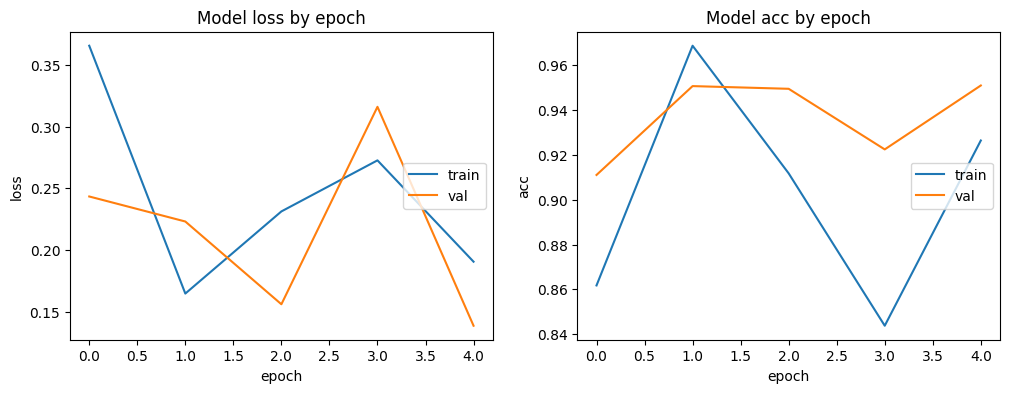

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_best_model_vgg16_opt.history['loss'])
plt.plot(history_best_model_vgg16_opt.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_best_model_vgg16_opt.history['accuracy'])
plt.plot(history_best_model_vgg16_opt.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

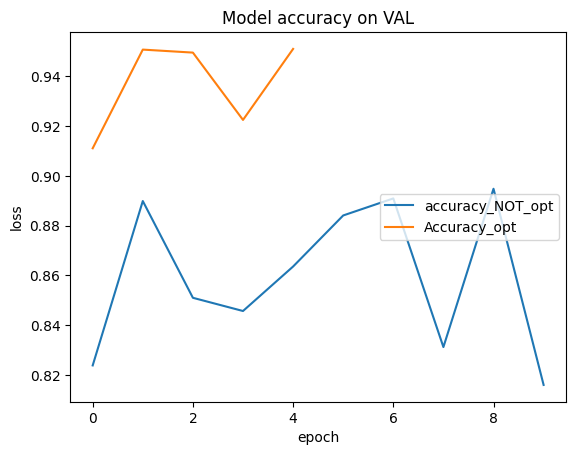

In [30]:
plt.plot(history_vgg6_nonopt.history['val_accuracy'])
plt.plot(history_best_model_vgg16_opt.history['val_accuracy'])
plt.title('Model accuracy on VAL')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy_NOT_opt', 'Accuracy_opt'], loc='right')

## 5- RESULTS

In [24]:
evaluation_opt = best_model_vgg16.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_opt[0])
print("Test Accuracy:", evaluation_opt[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 127ms/step - accuracy: 0.9571 - loss: 0.1220
Test Loss: 0.17920929193496704
Test Accuracy: 0.9403358697891235


In [ ]:
# After model training
best_model_vgg16.save('/kaggle/working/COVID-EX-Qu-dataset/OPT_vgg16_baret.h5')  # saves the entire model to a HDF5 file

213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 126ms/step


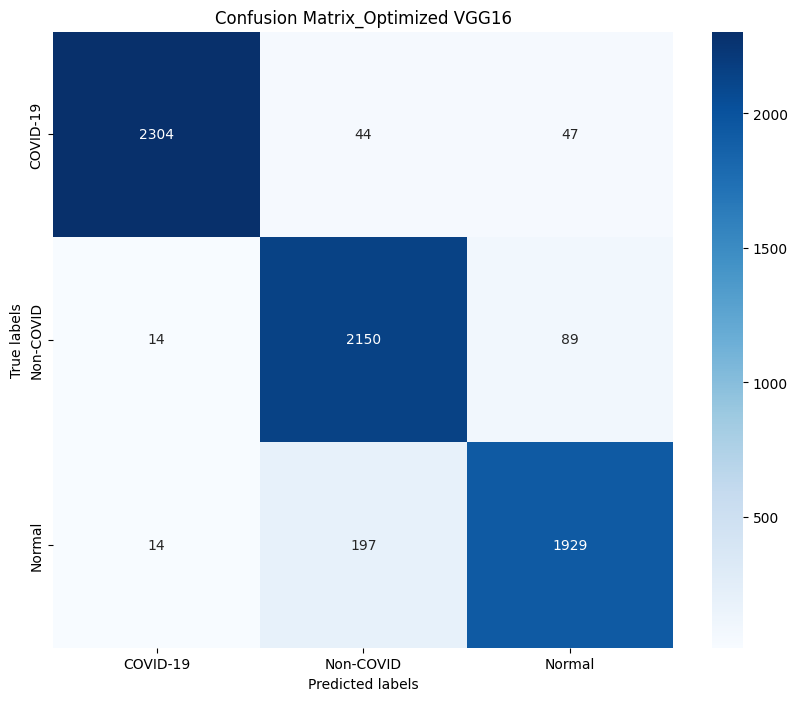

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
predictions = best_model_vgg16.predict(test_generator)
# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)
# Get the true classes
true_classes = test_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix_Optimized VGG16')
plt.show()